# Named Entity Recognition with SpaCy for CLS

This Notebook gives you a general overview of how to perform NER with the Natural Language Processing framework spaCy for literary-historical texts in **English**, **French**, **German** and **Dutch** in different scenarios:



1.   You do not have any labelled data to train your own NER-system, and the entities you want to recognize are part of the spaCy models.

  - Use off-the-shelf models with spaCy's **EntityRuler**.
  - Evaluate the performance manually.

2.   You do not have any labelled data to train your own NER-system, but you do want to recognize domain-specific entities which are not part of the spaCy models.

  -   Zero-shot approach through spaCy's **GliNER** model.

2.   You have enough annotations available to train your own pipeline to recognize domain-specific entities.

  - Train an NER-model on top of spaCy's language models.
  - Evaluate the performance quantitatively with **nervaluate**.


Each approach comes with its own pitfalls and advantages. SpaCy's models are not trained for literary-historical data, and will not perform perfectly when presented with OCR errors or unknown names and words, nor are they state-of-the art. When enhanced with the [EntityRuler](https://spacy.io/api/entityruler), they can however still be useful. Using the EntityRuler, you can introduce some hard-coded rules into your system.

The [GliNER model](https://github.com/urchade/GLiNER) is fairly new at the time of writing - and allows you to ask the model to recognize domain-specific entities. You can simply enter a domain-specific label (e.g.: "ships") you are interested in, and the model will use its embedding information to infer these entities from unseen text. Is it perfect? Far from it! But it can help you to **bootstrap annotations** (a first version of annotations to then introduce into your annotation software so they can be post-corrected) or create a large **domain-specific silver-labeled dataset**.


## Input and output


The notebook starts with **.txt-files** as input, and outputs a **.csv-file** in the following structure:

Text_name | Entity_text | Entity_sentence | Entity_category
-------------|------------|------------|------------
file.txt      |Rome| All roads lead to Rome. | LOCATION


---

📜🎓 **Side-note for the commmon good**

Are these methods all-encompassing? **No**.

Do we need to be full-fledged NLP-engineers to apply information extraction? **Not really**.

Do we need to know the pitfalls of applying these methods to our texts? **Big yes**.

Is the NLP-landscape currently changing at hyperspeed and may this Notebook be outdated when I read it? **Humongous yes**.

❗ So take this notebook as an example for you to build on, an example of how things **can** be done and not how they **should** be done. Don't stop exploring and learning, and remember that experimentation is the name of the game. There is [no such thing as a free lunch](https://en.wikipedia.org/wiki/No_free_lunch_theorem#:~:text=In%20mathematical%20folklore%2C%20the%20%22no,Free%20Lunch%20Theorems%20for%20Optimization%22.), and the same goes for modelling.

["*All models are wrong, some are useful*."](https://en.wikipedia.org/wiki/All_models_are_wrong)

---
❗🎓 To adapt and use this Notebook to produce entities for your own texts, you need to have an intuitive understanding of the following concepts:



*   [named entity recognition](https://en.wikipedia.org/wiki/Named-entity_recognition)
*   few-shot modelling
*   zero-shot modelling
*   Large Language Models (generative AI)
*   [BIO-labels / span evaluation](https://pypi.org/project/nervaluate/)
*   Evaluation metrics (F1, accuracy, precision, recall)
*   GitHub
*   [spaCy](https://spacy.io/)


To adapt the code, you need to know about:


* Functions in Python
* Pandas dataframe operations
* Jupyter Notebooks





# Load packages

In [ ]:
!pip install gliner-spacy
!pip install gliner

In [ ]:
import pandas as pd
import spacy
from tqdm.auto import tqdm
import os
import glob

from spacy.util import filter_spans
from spacy.tokens import Span
from spacy.language import Language
import re
from spacy import displacy
import io

from gliner import GLiNER
from gliner_spacy.pipeline import GlinerSpacy
from spacy.tokens import DocBin

In [ ]:
tqdm.pandas()

# Load corpus

First of all, we'll load in our texts and transform them into a Pandas DataFrame. Here, we're using an example corpus of travelogues in Dutch, German, English and French, ranging from the 18th to the 20th century. They are stored on a GitHub repository.

The way you choose to save and load in your texts is of course fully up to you!



In [ ]:
# Load in our example texts
!git clone https://github.com/TessDejaeghere/example_data_CLS.git

fatal: destination path 'example_data_CLS' already exists and is not an empty directory.


In [ ]:
path = "/content/example_data_CLS/"

In [ ]:
all_travelogues = []

for filename in glob.glob(f"{path}*/*.txt"):

  name_file = os.path.basename(filename) #find filename
  folder_name = os.path.dirname(filename).split("/")[-1] #find folder name (in our case: the language)

  with open(filename, "r") as travelogue:

    text = travelogue.read()
    travelogue_data = {"file": name_file, "text": text, "language": folder_name}
    all_travelogues.append(travelogue_data)

travel_df = pd.DataFrame(all_travelogues)

In [ ]:
#let's have a look at our data!
travel_df.sample(10)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#let's have a look at how many texts we have per language!
travel_df["language"].value_counts()

language
German     10
English    10
Dutch      10
French     10
Name: count, dtype: int64

In [ ]:
#Make separate corpora per language
English_corpus = travel_df[travel_df["language"] == "English"]
Dutch_corpus = travel_df[travel_df["language"] == "Dutch"]
German_corpus = travel_df[travel_df["language"] == "German"]
French_corpus = travel_df[travel_df["language"] == "French"]

# No data available (generic entities and rules)

If we want to train a domain-specific NER-system, we need to build a model and feed it with annotated data. This is usually a manual process, and takes a lot of time, effort and expertise.

If you have no or very limited annotated data available, but still want to perform named entity recognition on your data, there are a few methodologies you can consider within the spaCy framework:

*   Use SpaCy's language-specific off-the-shelf entity taggers to generate generic entities.
* Use SpaCy's EntityRuler to manually add missed examples to the model.

## spaCy's entity taggers for generic annotations

SpaCy has a couple of off-the-shelf models available for NER. Depending on the language, the entities the model can extract will differ. For one, the entities recognized by the English models are more extensive than the ones recognized by the Dutch, German and French models. Have a look at [spaCy's documentation](https://spacy.io/models) to see which model is most suitable for your use-case. You can choose the size of your model (sm = small, md = medium, lg = large and trf = transformer, which is an advanced model architecture type). The models are usually trained on newspapers or online material, and are **not trained to be used on literary-historical texts**. You can thus expect the model to make mistakes when it is presented with OCR errors or historical language.

Language | Model name
-------------|------------
English      |en_core_web_sm/md/lg/trf
Dutch        |nl_core_news_sm/md/lg
German         |de_core_news_sm/md/lg ; de_dep_news_trf
French         |fr_core_news_sm/md/lg ; fr_dep_news_trf

## What do the pipelines annotate?

The types of annotations you can expect and how they are defined differs per model. The English and Dutch models are trained to recognize a wide variety of entities, [German](https://spacy.io/models/de) and [French](https://spacy.io/models/fr) models are limited to LOCATION, ORGANISATION, PERSON and MISC (miscellaneous).

**Entities recognized by the English and Dutch models**

Entity | Description
-------------|------------
PERSON:      |People, including fictional.
NORP:        |Nationalities or religious or political groups.
FAC:         |Buildings, airports, highways, bridges, etc.
ORG:         |Companies, agencies, institutions, etc.
GPE:         |Countries, cities, states.
LOC:         |Non-GPE locations, mountain ranges, bodies of water.
PRODUCT:     |Objects, vehicles, foods, etc. (not services.)
EVENT:       |Named hurricanes, battles, wars, sports events, etc.
WORK_OF_ART: |Titles of books, songs, etc.
LAW:         |Named documents made into laws.
LANGUAGE:    |Any named language.
DATE:        |Absolute or relative dates or periods.
TIME:        |Times smaller than a day.
PERCENT:     |Percentage, including ”%“.
MONEY:       |Monetary values, including unit.
QUANTITY:    |Measurements, as of weight or distance.
ORDINAL:     |“first”, “second”, etc.
CARDINAL:    |Numerals that do not fall under another type.

## Building the spaCy pipeline

SpaCy is a natural language processing framework made to make your life a bit easier. It provides modules to build your own custom NLP-pipelines, depending on your unique needs. Here, we will build a pipeline with two elements:


1.   A NER-pipeline to recognize generic entities.
2.   A sentencizer to split up the text into sentences.



In [ ]:
# choose a language model
language = "en_core_web_sm"

In [ ]:
# Load the language model into your notebook
source_nlp = spacy.load("en_core_web_sm")

In [ ]:
#initiate a blank pipeline
nlp = spacy.blank("en")

In [ ]:
#make the pipeline an Entity Recognizer
nlp.add_pipe("ner", source=source_nlp)

In [ ]:
#add a sentencizer to the pipeline
nlp.add_pipe("sentencizer")

In [ ]:
#Let's check the order of our current custom pipeline!

nlp.pipeline

[('ner', <spacy.pipeline.ner.EntityRecognizer at 0x79b8f0b2d930>),
 ('sentencizer', <spacy.pipeline.sentencizer.Sentencizer at 0x79b8f0d18680>)]

In [ ]:
#all entity labels for this model
labels_list = list(nlp.get_pipe("ner").labels)


print(labels_list)

['CARDINAL', 'DATE', 'EVENT', 'FAC', 'GPE', 'LANGUAGE', 'LAW', 'LOC', 'MONEY', 'NORP', 'ORDINAL', 'ORG', 'PERCENT', 'PERSON', 'PRODUCT', 'QUANTITY', 'TIME', 'WORK_OF_ART']


In [ ]:
def entity_labeler(text, pipe = nlp, labels = labels_list):
  """

  Args:
    text: text you want to label
    pipe: pipeline you want to use
    labels: labels you want to recognize (limited to the labels recognized by spacy!)

  Returns: a list with tuples per found entity: [(entity, label, sentence), (entity, label, sentence)]

  """

  #the text length allowed by spaCy allows only 100.000 characters per text.
  #increase at your own risk.
  if len(text) > 1000000:
    pipe.max_length = len(text)

  # apply spacy's text analysis pipe to the document
  doc = pipe(text)

  # fetch entities, entity types/labels and the sentence the entity was fetched from
  entities = []
  for ent in doc.ents:
    if ent.label_ in labels:
      entity = str(ent) #get the entity
      sentence = str(ent.sent) #get the sentence
      label = ent.label_ #get the label

      entities.append((entity, label, sentence))

  return entities

In [ ]:
# apply the entity labeler to your corpus!
# Say we are only interested in the PERSON entity here.
# progress_apply adds a useful tqdm progress bar to this function.

English_corpus["result"] = English_corpus.text.progress_apply(entity_labeler)

  0%|          | 0/10 [00:00<?, ?it/s]

<ipython-input-17-2118d8d4aa73>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  English_corpus["result"] = English_corpus.text.progress_apply(entity_labeler)


In [ ]:
# Let's have a look at our first two examples
# we can see the results column is added now!

English_corpus.head(2)

,file,text,language,result
10,Roman_Holidays_and_Others.txt,Title: Roman Holidays and Others\nAuthor: W. D...,English,"[(Roman Holidays and Others, PERSON, Title: Ro..."
11,Italian_Highways_and_Byways_from_a_Motor_Car.txt,Title: Italian Highways and Byways from a Moto...,English,"[(Italian, NORP, Title: Italian Highways and B..."


As we can see, we have now added the results of our NER to our dataframe. Cool! However, I want to transform the results into one line per extracted entity, so it's easier to inspect. We don't have a way to quantitatively evaluate our approach since we don't have any gold standard labels in this case - but what we can do is inspect some of the labeled instances manually and see if these off-the-shelf tools are fit for our purpose.

In [ ]:
# If we explode the results section, it will make a copy of the fulltext column for each instance.
# This may be a bit heavy on our machine, so we can choose to remove this column. We can always re-add it later using the file id.

English_corpus.drop("text", axis =1, inplace = True)

<ipython-input-19-947e6ec73fd9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  English_corpus.drop("text", axis =1, inplace = True)


In [ ]:
# "explode" the results section to one entity per line.
English_corpus = English_corpus.explode("result")

In [ ]:
#split the result of the NER pipeline into separate columns entity, label and sentence

English_corpus['entity'], English_corpus['label'], English_corpus["sentence"] = zip(*English_corpus.result)

In [ ]:
# We split the result column into separate entity, label and sentence columns, which are more useful to work with.
# We can now get rid of the result column.

English_corpus.drop("result", axis = 1, inplace = True)

In [ ]:
English_corpus.head()

,file,language,entity,label,sentence
10,Roman_Holidays_and_Others.txt,English,Roman Holidays and Others,PERSON,Title: Roman Holidays and Others\nAuthor: W. D...
10,Roman_Holidays_and_Others.txt,English,W. D. Howells,PERSON,Title: Roman Holidays and Others\nAuthor: W. D...
10,Roman_Holidays_and_Others.txt,English,HARPER & BROTHERS\nPlace,ORG,Title: Roman Holidays and Others\nAuthor: W. D...
10,Roman_Holidays_and_Others.txt,English,New York / London,GPE,Title: Roman Holidays and Others\nAuthor: W. D...
10,Roman_Holidays_and_Others.txt,English,I. UP,ORG,Title: Roman Holidays and Others\nAuthor: W. D...


In [ ]:
English_corpus.sample(10)

,file,language,entity,label,sentence
14,Rome.txt,English,late years,DATE,"The taste for\nvilla-building is, however, not..."
17,A_Wanderer_in_Venice.txt,English,Venice,GPE,"As\nto how he performed his consular duties, s..."
13,Florence_and_Northern_Tuscany_with_Genoa.txt,English,house of idols,ORG,"Then in 1072 they\npulled down that old ""house..."
17,A_Wanderer_in_Venice.txt,English,only four or,CARDINAL,Castel Franco is one of the last cities of the...
11,Italian_Highways_and_Byways_from_a_Motor_Car.txt,English,Idiot,WORK_OF_ART,"Idiot!"" """
13,Florence_and_Northern_Tuscany_with_Genoa.txt,English,Arab,NORP,\n\nBut Pisa was not yet done with the Arab.
15,Vistas_in_Sicily.txt,English,one evening,TIME,"At a little mountain hotel, one evening at din..."
12,Studies_of_Travel_Italy.txt,English,Pisgah,PERSON,\n\nWe took a kind of Pisgah view of Antemnæ b...
11,Italian_Highways_and_Byways_from_a_Motor_Car.txt,English,first,ORDINAL,Whatever the fascination of Rome may be it is ...
15,Vistas_in_Sicily.txt,English,Arabic,LANGUAGE,An Arabic frieze about the bare exterior sugge...


In [ ]:
#Let's see how many entities we recognized!
English_corpus["label"].value_counts()

label
PERSON         14866
GPE            10321
ORG             9307
NORP            6327
CARDINAL        5786
DATE            4995
LOC             1457
ORDINAL         1454
PRODUCT          970
TIME             755
WORK_OF_ART      748
FAC              681
LANGUAGE         352
QUANTITY         314
MONEY            143
LAW              129
EVENT             95
PERCENT            3
Name: count, dtype: int64

## Add rule-based custom labels

In our example, we can see that the NER-pipeline often extracts the name of Saints and Popes in our corpus. However, for our use-case, we want to add a separate entity RELIGIOUS_FIGURE for these entities, and add it to the pipe.

We know what the names of Saints and Popes look like, so we can easily write a REGEX-rule for that. We then add a heuristic function to the spaCy pipeline, which was adapted from the amazing notebooks made by[ Dr. W.J.B. Mattingly](https://ner.pythonhumanities.com/04_05_building_holocaust_pipeline_rules_based.html). Be sure to check this out and get creative!

In [ ]:
religious_rows = English_corpus[English_corpus["entity"].str.contains(r'pope|saint', case=False)]

In [ ]:
religious_rows.sample(10)

,file,language,entity,label,sentence
13,Florence_and_Northern_Tuscany_with_Genoa.txt,English,Pope Gelasius\nII,PERSON,"For the Genoese, never content that she should..."
13,Florence_and_Northern_Tuscany_with_Genoa.txt,English,Saints,ORG,Full of a grave earnestness and full of ardent...
18,A_Wanderer_in_Florence.txt,English,Pope,PERSON,"The design is all Donatello's, and his\nthe re..."
13,Florence_and_Northern_Tuscany_with_Genoa.txt,English,Pope,PERSON,\n\nThe fifth inscription refers to the victor...
13,Florence_and_Northern_Tuscany_with_Genoa.txt,English,Saints,PRODUCT,"Thus, while Florence\nwas the most influential..."
11,Italian_Highways_and_Byways_from_a_Motor_Car.txt,English,Pope Pius II,PERSON,"More than by\nanything else, Siena is brought ..."
18,A_Wanderer_in_Florence.txt,English,Saints,ORG,"1305, a Virgin and Child with various Saints\n..."
11,Italian_Highways_and_Byways_from_a_Motor_Car.txt,English,Saint Catherine,PERSON,"More than by\nanything else, Siena is brought ..."
16,Cathedral_Cities_of_Italy.txt,English,Pope,PERSON,"Pope, Paul IV."
19,Venice.txt,English,Saint Blaise,FAC,There are now at Saint Blaise no pastoral and ...


In the code snippet below, we write out a heuristic rule and add it to the pipeline.

In [ ]:
saints_pattern = r"((Pope|Saint)\s[A-Z][a-zA-Z']+(\s(?:[IVXLCDM]+|[A-Z][a-zA-Z']+))?)"
@Language.component("find_religious_figures")
def find_religious_figures(doc):
    text = doc.text
    saint_ents = []
    original_ents = list(doc.ents)
    for match in re.finditer(saints_pattern, doc.text):
        start, end = match.span()
        span = doc.char_span(start, end)
        if span is not None:
            saint_ents.append((span.start, span.end, span.text))
    for ent in saint_ents:
        start, end, name = ent
        per_ent = Span(doc, start, end, label="RELIGIOUS_FIGURE")
        original_ents.append(per_ent)
    filtered = filter_spans(original_ents)
    doc.ents = filtered
    return (doc)



nlp.add_pipe("find_religious_figures", before="ner")

<function __main__.find_religious_figures(doc)>

In [ ]:
#check what's in our pipeline.
nlp.pipeline

[('find_religious_figures', <function __main__.find_religious_figures(doc)>),
 ('ner', <spacy.pipeline.ner.EntityRecognizer at 0x7f3d2e13dcb0>),
 ('sentencizer', <spacy.pipeline.sentencizer.Sentencizer at 0x7f3d2b21c780>)]

In [ ]:
doc = nlp("We, Pope Pius XII and I, were wandering in Rome.")

In [ ]:
# Displacy shows the entities in a nice way. Let's check!

displacy.render(doc, style="ent")

## spaCy's EntityRuler

Woops, our model sometimes recognizes "Genoa", the Italian city, as a person. We want to overwrite this rule, so Genoa is always correctly identified as a GPE.

SpaCy's EntityRuler to the rescue: let's add a pattern!

In [ ]:
English_corpus[English_corpus["entity"] == "Genoa"]

,file,language,entity,label,sentence
10,Roman_Holidays_and_Others.txt,English,Genoa,GPE,"Again there were those ""Silent pinnacles of ag..."
10,Roman_Holidays_and_Others.txt,English,Genoa,PERSON,Once more it did not matter; what is certain i...
10,Roman_Holidays_and_Others.txt,English,Genoa,ORG,"That was what we now got at Genoa, and we coul..."
10,Roman_Holidays_and_Others.txt,English,Genoa,PERSON,\nAfter the creamy and rosy tints of those dau...
10,Roman_Holidays_and_Others.txt,English,Genoa,PERSON,"Most European towns have red tiled roofs, whic..."
...,...,...,...,...,...
17,A_Wanderer_in_Venice.txt,English,Genoa,PERSON,He\nfound himself at once involved in the war ...
17,A_Wanderer_in_Venice.txt,English,Genoa,PERSON,\n\n\n\n\nCHAPTER XXV\n\nS. ELENA AND THE LIDO...
17,A_Wanderer_in_Venice.txt,English,Genoa,GPE,\n\nThe shore of the lagoon between the bridge...
17,A_Wanderer_in_Venice.txt,English,Genoa,PERSON,One\nafternoon I watched a match there between...


In [ ]:
#Create the EntityRuler and add it to the pipe.
#Make sure overwrite_ents is set to true if you want your patterns to take precedence over the generic entities.

ruler = nlp.add_pipe("entity_ruler", config={"overwrite_ents": True})

#List of Entities and Patterns
patterns = [
                {"label": "GPE", "pattern": "Genoa"},
            ]

ruler.add_patterns(patterns)

In [ ]:
#Let's take a wrongly classified example and test out our new pattern rule!

doc = nlp("""Once more it did not matter; what is certain is that the golden sun of the soft January afternoon
turned to crimson and left the last of them suffused in dim rose before we drifted into Genoa
and came to anchor at dusk beside a steamer which had left New York on the same day as ours.""")

In [ ]:
displacy.render(doc, style="ent")

💪🏼 **It works! **

Our pipeline now includes a couple of interesting corpus-specific rules which we can use to apply to our entire corpus. This is of course **language- and domain-specific.**. An important element herein is to know what you're looking for in your corpus.

Let's apply our brand-new NLP-pipeline to our entire corpus, and export the results to a .csv-file.

In [ ]:
nlp.pipeline

[('find_religious_figures', <function __main__.find_religious_figures(doc)>),
 ('ner', <spacy.pipeline.ner.EntityRecognizer at 0x7f3d2e13dcb0>),
 ('sentencizer', <spacy.pipeline.sentencizer.Sentencizer at 0x7f3d2b21c780>),
 ('entity_ruler', <spacy.pipeline.entityruler.EntityRuler at 0x7f3d23416840>)]

In [ ]:
#Load the corpus again
English_corpus = travel_df[travel_df["language"] == "English"]

In [ ]:
#apply our entity labeler with the new pipe we made
English_corpus["result"] = English_corpus.text.progress_apply(entity_labeler)

  0%|          | 0/10 [00:00<?, ?it/s]

<ipython-input-69-9d351e795d02>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  English_corpus["result"] = English_corpus.text.progress_apply(entity_labeler)


In [ ]:
English_corpus.drop("text", axis =1, inplace = True)
English_corpus = English_corpus.explode("result")
English_corpus['entity'], English_corpus['label'], English_corpus["sentence"] = zip(*English_corpus.result)
English_corpus.drop("result", axis = 1, inplace = True)

<ipython-input-70-3869d7482d5a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  English_corpus.drop("text", axis =1, inplace = True)


In [ ]:
English_corpus["label"].value_counts()

label
PERSON              14565
GPE                 10567
ORG                  9259
NORP                 6326
CARDINAL             5786
DATE                 4995
LOC                  1454
ORDINAL              1454
PRODUCT               970
TIME                  755
WORK_OF_ART           746
FAC                   671
LANGUAGE              352
QUANTITY              314
RELIGIOUS_FIGURE      167
MONEY                 143
LAW                   129
EVENT                  95
PERCENT                 3
Name: count, dtype: int64

In [ ]:
English_corpus.sample(10)

,file,language,entity,label,sentence
19,Venice.txt,English,St. Mark's,GPE,Often he visited the painters' benches in the ...
13,Florence_and_Northern_Tuscany_with_Genoa.txt,English,Byron,ORG,In the meanwhile Lord Byron's carriage with Mr...
13,Florence_and_Northern_Tuscany_with_Genoa.txt,English,two,CARDINAL,"If we compare,\nhere in the Pitti Gallery, the..."
17,A_Wanderer_in_Venice.txt,English,Alvise,PERSON,\n\nOther Doges who lie here are the two Conta...
15,Vistas_in_Sicily.txt,English,eighty,CARDINAL,"To-day the Titan sleeps, but in the eighty maj..."
13,Florence_and_Northern_Tuscany_with_Genoa.txt,English,Alps,LOC,Title: Florence and Northern Tuscany with Geno...
13,Florence_and_Northern_Tuscany_with_Genoa.txt,English,Casentino,GPE,"So he set out again, not without\ntears, comin..."
12,Studies_of_Travel_Italy.txt,English,Frenchman,NORP,He curses every Lucumo whose image he sees for...
18,A_Wanderer_in_Florence.txt,English,Rucellai,PERSON,"The Rucellai family's present palace, I\nmay s..."
11,Italian_Highways_and_Byways_from_a_Motor_Car.txt,English,Bishop,ORG,Among the former was the\ncelebrated Guglielmi...


## Save your pipeline to disk

In [ ]:
nlp.meta["name"] = "travelogues_ner"
nlp.meta["version"] = '0.0.1'
nlp.meta["author"] = "Tess Dejaeghere"
nlp.meta["author_email"] = "tess.dejaeghere@ugent.be"
nlp.meta["description"] = "This pipeline recognizes generic entities and religious figures."
nlp.to_disk("/content/drive/MyDrive/1. WORK IN PROGRESS/CLS/travelogues_pipe")

## Export resulting entities to a .csv

In [ ]:
#The io.StringIO is added to avoid adding an "Unnamed" column to the dataframe.

English_corpus.to_csv(io.StringIO("/content/drive/MyDrive/1. WORK IN PROGRESS/PhD/ABSA notebooks/data/travelogues_ner_english.csv"))

# No data available (zero-shot with GliNER)


## Zero-shot GliNER to generate annotations

GliNER is spaCy's zero-shot NER annotator, which can be made domain-specific by simply entering the desired labels. There are multiple models available on their GitHub (https://github.com/urchade/GLiNER). At the time of writing, the best models available for English, Dutch, French and German are:

*  urchade/gliner_multi (multilingual)
*  urchade/gliner_large-v2 (English)


This model **is far from perfect**, but can be used to generate annotations or silver-labeled data to train a domain-specific model.
[According to their paper](https://arxiv.org/abs/2311.08526), at the time of writing, the compact NER-model has outperformed the popular chat-model ChatGPT on multiple NER benchmarks.



---


❗ Since the NLP-field, and specifically the strand of LLMs and zero-shot modelling is moving extremely quickly, this module may have significantly changed when you're starting to use it.

Let's see what the multilingual model can do for us on our **Dutch corpus**!
We'll start by loading the most recent multilingual model at the time of writing. Code was fetched from the[ demo introduced by the makers of GliNER](https://colab.research.google.com/drive/1mhalKWzmfSTqMnR0wQBZvt9-ktTsATHB?usp=sharing#scrollTo=ILTMzrk5afxY).

In [ ]:
model = GLiNER.from_pretrained("urchade/gliner_multi-v2.1")
model.eval()
print("ok")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/1.16G [00:00<?, ?B/s]

gliner_config.json:   0%|          | 0.00/477 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:560: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

ok


We're interested to see how well the model does on entities beyond the generic ones introduced by SpaCy! The texts we're working with are Dutch travel texts, often written by Dutch colonialists who write about their surroundings. The text we're testing our methodology on is "*Reize in eenen Palanquin; of lotgevallen en merkwaardige aanteekeningen op eene reize langs de kusten Orixa en Choromandel*." written by *J.G. Haffner* in 1808 and fetched from the [DBNL online repository](https://www.dbnl.org/tekst/haff003reiz01_01/haff003reiz01_01_0002.php).

🌺🐱
Let's see how well the model does when we ask it to recognize fauna and flora-entities in a part of the text.

In [ ]:
test_text = """De Manga is eene smakelijke, aangename en onschadelijke vrucht;
hebbende de grootte van een' middelmatigen appel, doch langwerpig rond.
Men kan deze vrucht, wanneer zij rijp is, tot verzadiging eten, zonder dat het de gezondheid schadelijk is,
mits men er geen koud water op drinkt, als wanneer ze somtijds den bloedgang zoude kunnen veroorzaken.
Deze vrucht is genoeg beschreven en bekend, zoodat ik het onnoodig oordeel, er iets meer van te zeggen,
alleenlijk zal ik er nog bijvoegen, dat, alhoewel de Mangaboom, doorgaans, verbazend veel draagt,
echter iedere vrucht op zoodanigen boom eenen min of meer bijzonderen verschillenden smaak heeft."""

In [ ]:
custom_labels = ["fauna", "flora"]

entities = model.predict_entities(test_text, custom_labels, threshold=0.4)

for entity in entities:
    print(entity["text"], "=>", entity["label"])

de Mangaboom => flora


Impressive, **without any training**, the model is able to recognize all the fauna and flora-entities in our Dutch text. On top of that, the text isn't even modern, but written in 19th-century Dutch! Let's see how we can implement this functionality in a spaCy pipeline.

We specify which model we want to use, the **labels**, the style (**ent** = entity) and the chunk size we want to apply to our text. The **chunk size** is important, because this is the context we give to our model. The **threshold** allows the model to predict more entities, or less entities, depending on the context.

In [ ]:
# We configure the custom spaCy pipeline.
custom_spacy_config = {
    "gliner_model": "urchade/gliner_multi-v2.1",
    "chunk_size": 250,
    "labels": custom_labels,
    "style": "ent",
    "threshold": 0.3
}

# Initialize a blank English spaCy pipeline and add GLiNER
nlp_zero = spacy.blank("en")

# add zero_shot NER model
nlp_zero.add_pipe("gliner_spacy", config=custom_spacy_config)

# add sentencizer
nlp_zero.add_pipe("sentencizer")

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:560: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [ ]:
nlp_zero.pipeline

[('gliner_spacy', <gliner_spacy.pipeline.GlinerSpacy at 0x77fde72a91b0>),
 ('sentencizer', <spacy.pipeline.sentencizer.Sentencizer at 0x77fde94dd200>)]

In [ ]:
def zero_shot_labeler(text, pipe = nlp_zero, labels = custom_labels):
    # apply spacy's text analysis pipe to the document
  doc = pipe(text)

  # fetch entities, entity types/labels and the sentence the entity was fetched from
  entities = []
  for ent in doc.ents:
    if ent.label_ in labels:
      entity = str(ent) #get the entity
      label = ent.label_ #get the label
      start_ent = ent.start #get start index of entity
      end_ent = ent.end #get end index of entity
      sentence = str(ent.sent)

      entities.append((entity, label, start_ent, end_ent, sentence))

  return entities

In [ ]:
example_corpus = Dutch_corpus[1:2]

In [ ]:
example_corpus["results"] = example_corpus.text.progress_apply(zero_shot_labeler) #This may take a while...

  0%|          | 0/1 [00:00<?, ?it/s]

<ipython-input-30-47e5e43d2bc6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  example_corpus["results"] = example_corpus.text.progress_apply(zero_shot_labeler) #This may take a while...


In [ ]:
example_corpus.keys()

Index(['file', 'language', 'results'], dtype='object')

In [ ]:
example_corpus.iloc[0]["results"]

'Orixa'

In [ ]:
example_corpus = example_corpus.explode("results")

example_corpus['entity'], example_corpus['label'], example_corpus["start_entity"], example_corpus["end_entity"], example_corpus["sentence"] = zip(*example_corpus.results)

In [ ]:
example_corpus.drop("text", axis = 1, inplace = True)

In [ ]:
example_corpus.drop("results", axis = 1, inplace = True)

In [ ]:
example_corpus.head(10)

,file,language,entity,label,start_entity,end_entity,sentence
21,haff003reiz01_01.txt,Dutch,Orixa,flora,18,19,"﻿\n\n\n\n\n\nReize in eenen palanquin, of Lotg..."
21,haff003reiz01_01.txt,Dutch,Choromandel,flora,20,21,"﻿\n\n\n\n\n\nReize in eenen palanquin, of Lotg..."
21,haff003reiz01_01.txt,Dutch,orixa,flora,215,216,\n \n[pagina I]\nREIZE in eenen PALANQUIN; of ...
21,haff003reiz01_01.txt,Dutch,choromandel,flora,217,218,\n \n[pagina I]\nREIZE in eenen PALANQUIN; of ...
21,haff003reiz01_01.txt,Dutch,orixa,flora,542,543,[pagina I] REIZE in eenen PALANQUIN; of lotg...
21,haff003reiz01_01.txt,Dutch,choromandel,flora,544,545,[pagina I] REIZE in eenen PALANQUIN; of lotg...
21,haff003reiz01_01.txt,Dutch,orixa,flora,621,622,[pagina III] REIZE in eenen PALANQUIN; of lo...
21,haff003reiz01_01.txt,Dutch,choromandel,flora,623,624,[pagina III] REIZE in eenen PALANQUIN; of lo...
21,haff003reiz01_01.txt,Dutch,Indianen,fauna,1060,1061,"Ik heb, daar en tegen, de Indianen, bij alle..."
21,haff003reiz01_01.txt,Dutch,natuur,flora,1646,1647,"Hij zal deze volkeren, zonder zich aan derzelv..."


In [ ]:
path = "/path"
example_corpus.to_csv(path)

## Inspect the results of GliNER

There is no way to quantitatively evaluate the results of GliNER if we don't have any gold standard data to compare it to. As far as I know, GliNER also doesn't allow for a few-shot setting, where you can introduce some examples to the model to steer it in the correct direction.

What we can do however, is have a detailed look at the results returned by the model on a couple of texts. If the results are sufficient for our use-case, we can apply them to a larger corpus. If not, we can try to adjust the search terms (custom labels) we introduced and apply it again.

In [ ]:
example_corpus.sample(20)

,file,language,results,entity,label,start_entity,end_entity,sentence
21,haff003reiz01_01.txt,Dutch,"(slang, fauna, 106738, 106739, Door eene slang...",slang,fauna,106738,106739,"Door eene slang gebeten, mager, bleek en ontda..."
21,haff003reiz01_01.txt,Dutch,"(Mooren, fauna, 144370, 144371, Van stoelen en...",Mooren,fauna,144370,144371,Van stoelen en tafels weten de Mooren echter o...
21,haff003reiz01_01.txt,Dutch,"(mamia, fauna, 162008, 162009, De roeijers zwo...",mamia,fauna,162008,162009,"De roeijers zwommen hier en daar, en niet ver ..."
21,haff003reiz01_01.txt,Dutch,"(kokos, flora, 79022, 79023, Deze prachtige ma...",kokos,flora,79022,79023,"Deze prachtige majestueuze kokos en palmtopen,..."
21,haff003reiz01_01.txt,Dutch,"(shorpojaan, fauna, 96126, 96127, Dat die shor...",shorpojaan,fauna,96126,96127,Dat die shorpojaan ook juist op reis moest zijn!
21,haff003reiz01_01.txt,Dutch,"(orixa, flora, 215, 216, \n \n[pagina I]\nREIZ...",orixa,flora,215,216,\n \n[pagina I]\nREIZE in eenen PALANQUIN; of ...
21,haff003reiz01_01.txt,Dutch,"(radde nimsen, fauna, 80900, 80902, Hoe vlug e...",radde nimsen,fauna,80900,80902,Hoe vlug en los zijn alle de bewegingen dezer ...
21,haff003reiz01_01.txt,Dutch,"(Betelbladeren, flora, 169978, 169979, De Bete...",Betelbladeren,flora,169978,169979,De Betelbladeren hebben eenen aromatischen of ...
21,haff003reiz01_01.txt,Dutch,"(koebeesten, fauna, 74925, 74926, Bij ons zoud...",koebeesten,fauna,74925,74926,"Bij ons zoude men zulk een beschadigd dier, in..."
21,haff003reiz01_01.txt,Dutch,"(areekboom, flora, 84458, 84459, Als een woud ...",areekboom,flora,84458,84459,"Als een woud van masten, vertoonen zich de dre..."


# Domain-specific labelled data available (training)



*   Train an entity/aspect tagger on top of SpaCy's models
*   Evaluate our model on a dev set



---

❗ Depending on our use-case, we can decide to use the silver-labelled data made by GilNER or another tool to train our domain-specific model!


## Train entity/aspect tagger with spaCy

If we have enough domain-specific labelled data available, we can fine-tune spaCy's language model and save it to recognize domain-specific entities!
Let's try fine-tuning it on a very small training dataset which contains FAUNA and FLORA-entities.



1.   Prepare the training data in the docBin format which spaCy expects.
2.   Download the correct .config file for ner in your language from the spaCy website.
3.   Check how well your model performs on a development set. Look up some information on development and test sets if you're not sure what this is for.
4.   Save your model, which can now be applied to unseen data!



In [ ]:
training_df = "example_data_CLS/FR_fauna_flora.csv"

In [ ]:
sentences = list(training_df["_sentence_text"])
labels = list(training_df["aspect_cat"])

In [ ]:
#spacy expects the training data in a certain format.
#Here, we extract the indices of where the entity begins in the sentence, and where it ends.

beginnings = []
endings = []

for sentence, entity in zip(sentences, entities):
    for match in re.finditer(entity, sentence):
        beginnings.append(match.start())
        endings.append(match.end())

In [ ]:
# use a sample of your training data for development, and another sample for training.

DEV_DATA = TRAIN_DATA[:10]
TRAIN_DATA = TRAIN_DATA[10:]

In [ ]:
#nlp = spacy.blank("en") # load a new spacy model
nlp = spacy.load("fr_core_news_lg") # load other spacy model

#choose a path to save your train.spacy and dev.spacy files
path = '/home/tess/generative_exp/Deliverables/'


def convert(path, dataset):
    nlp = spacy.blank("pt")
    db = DocBin()
    for text, annot in tqdm(dataset):
            doc = nlp.make_doc(text)
            ents = []
            for start, end, label in annot["entities"]:
                span = doc.char_span(start, end, label=label, alignment_mode="contract")
                if span is None:
                    print("Skipping entity")
                else:
                    ents.append(span)
            doc.ents = ents
            db.add(doc)
    db.to_disk(path)

convert("train.spacy", TRAIN_DATA)
convert("dev.spacy", DEV_DATA)

SpaCy makes it easy for you to configure your model with all the adequate parameters for your task. Select "ner" in the choice module on the [website](https://spacy.io/usage/training#config), download the file, and upload it to your Jupyter Notebook environment.

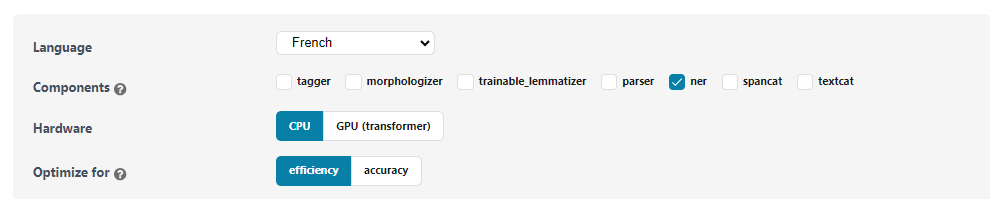



In [ ]:
path_to_config = "path"
path_to_training_data = "train" #train.spacy
path_to_development_data = "dev" #dev.spacy

In [ ]:
# initiate the pipeline using the config file.

!python -m spacy init config path_to_config --lang pt --pipeline ner --optimize efficiency --force

In [ ]:
# train the model and evaluate it on the development set.

!python -m spacy train path_to_config --output ./ --paths.train path_to_training_data --paths.dev path_to_development_data

In [ ]:
# Load our best model and apply it to an unseen document!

nlp = spacy.load("model-best")

# Alternative sources to check

The CLS-project does not aim to reinvent the wheel. Rather, we try to build a reusable infrastructure for Digital Humanists looking to incorporate named entity recognition or sentiment analysis in their work. There are a lot of interesting sources out there to check!

*   This [YouTube Channel](https://www.youtube.com/@python-programming) has a great overview of NLP applications for Digital Humanities. If you're looking for step-by step video tutorials for spaCy aimed at Digital Humanists, this is it! Some code we used here is based on these tutorials.